![logo](https://media.rbcdn.ru/media/upload_tmp/2018/rb-1200-628.png)

# HackTheRealty Hackathon by Yandex

**by team GORNYAKI (Tsepa Oleksii and Samoshyn Andriy [Ukraine, KPI, IASA])**

**Task:** to build a model that predicts the duration of the exposure of advert for the sale of a flat on Yandex.Realty.

**Data:** adverts from the Yandex.Realty estate archive with exposure dates. By placing an object on Yandex.Realty, everyone wants to sell or rent it as quickly as possible for the maximum price for this object. The archive of the service contains hundreds of thousands of publications with exposure dates (dates for placing and withdrawing advertisements). On the service, organizers want to tell users how long they will wait for a buyer or tenant for their property given the current characteristics.

**The metric by which the solutions are evaluated is written as follows:**

$$metric = -{1 \over l}\sum\limits_{i=1}^{l} {\exp}^{|prediction_i-taget_i|} -1$$

To construct the target variable, the placement period is divided into several classes, each of which corresponds to an integer: **"less than 7 days" (1), "7-14 days" (2), "15-30 days" (3), "30- 70 days "(4)," more than 70 days "(5).**

In [1]:
def metric(y_true, y_real):
    return -1*np.mean(np.exp(np.abs(y_true-y_real)) - 1)

# Understanding the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('/kaggle/input/yandex-exposition-task/exposition_train.tsv', sep='\t')
test = pd.read_csv('/kaggle/input/yandex-exposition-task/exposition_test.tsv', sep='\t')
submission = pd.read_csv('/kaggle/input/yandex-exposition-task/exposition_sample_submission.tsv', sep='\t')

In [3]:
train.head()

,building_series_id,site_id,target,parking,target_string,build_year,expect_demolition,main_image,latitude,total_area,...,area,kitchen_area,day,longitude,price,flats_count,building_type,balcony,locality_name,renovation
0,1564812,0,1,OPEN,LESS_7,2005,False,//avatars.mds.yandex.net/get-realty/903734/add...,55.645313,105.000000,...,105.000000,15.0,2018-07-15,37.657490,95000,407,MONOLIT,BALCONY,Москва,EURO
1,1564812,0,2,CLOSED,7_14,2010,False,//avatars.mds.yandex.net/get-realty/1702013/ad...,55.537102,40.000000,...,40.000000,10.0,2019-01-18,37.155632,25000,40,MONOLIT,UNKNOWN,посёлок Первомайское,COSMETIC_DONE
2,663302,0,2,OPEN,7_14,1995,False,//avatars.mds.yandex.net/get-realty/924080/add...,55.662956,37.599998,...,37.599998,0.0,2018-04-24,37.555466,26000,472,PANEL,LOGGIA,Москва,GOOD
3,1564812,0,2,OPEN,7_14,2018,False,//avatars.mds.yandex.net/get-realty/1521999/ad...,55.669151,80.000000,...,80.000000,20.0,2019-02-19,37.285000,35000,156,PANEL,UNKNOWN,Одинцово,GOOD
4,1564812,0,3,UNKNOWN,14_30,2004,False,//avatars.mds.yandex.net/get-realty/50286/f5c8...,55.828518,100.000000,...,100.000000,0.0,2017-08-08,37.361897,80000,31,MONOLIT,UNKNOWN,Москва,EURO


In [4]:
print(f'NaN value in train: {round(train.isna().sum().sum() / (train.shape[0]*train.shape[1]), 4)*100}%')
print(f'NaN value in test: {round(test.isna().sum().sum() / (test.shape[0]*test.shape[1]), 4)*100}%')

NaN value in train: 0.01%
NaN value in test: 0.04%


In [5]:
train.columns

Index(['building_series_id', 'site_id', 'target', 'parking', 'target_string',
       'build_year', 'expect_demolition', 'main_image', 'latitude',
       'total_area', 'ceiling_height', 'rooms', 'floors_total', 'id',
       'living_area', 'floor', 'is_apartment', 'building_id', 'has_elevator',
       'studio', 'unified_address', 'area', 'kitchen_area', 'day', 'longitude',
       'price', 'flats_count', 'building_type', 'balcony', 'locality_name',
       'renovation'],
      dtype='object')

In [6]:
train['target'].value_counts(normalize=True)

2    0.227032
3    0.217119
5    0.211532
1    0.203655
4    0.140662
Name: target, dtype: float64

**Important notes after elemental analysis:**

* unnecessary columns - **'site_id'** (columns in constant 0), **'target_string'**, **'main_image'** (at the moment we are working with tabular data), **'total_area'** (duplicates a column 'area), **'id'**, **'builing_id'** (the organizers said this was a wrong column)
* no missing data? *(we'll find out later)*
* almost all classes are balanced

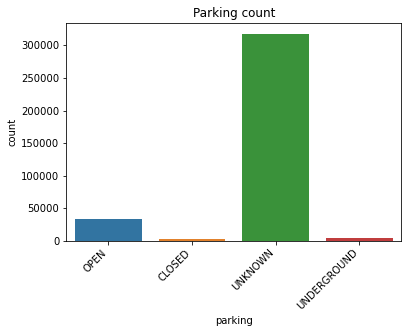

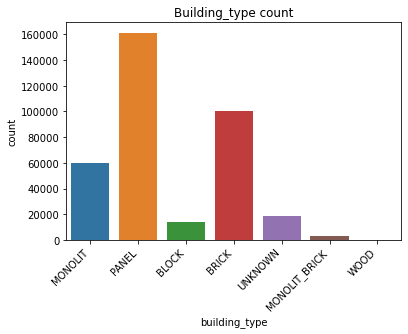

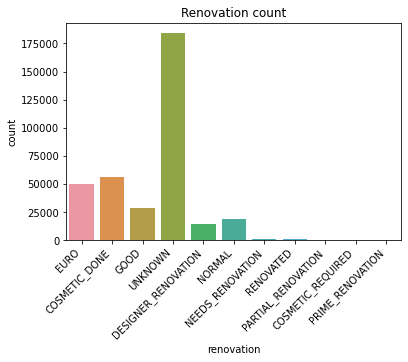

In [7]:
sns.countplot(data=train, x='parking').set_title('Parking count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right')
plt.show()
sns.countplot(data=train, x='building_type').set_title('Building_type count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right')
plt.show()
sns.countplot(data=train, x='renovation').set_title('Renovation count')
plt.xticks(
    rotation=45, 
    horizontalalignment='right')
plt.show()

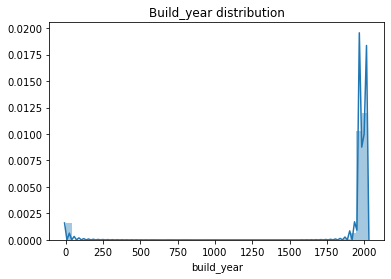

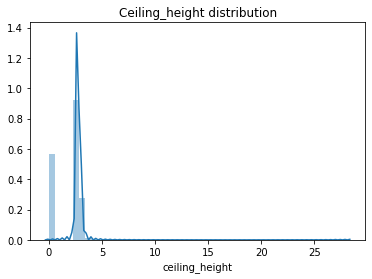

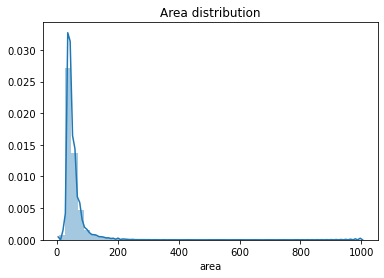

In [8]:
sns.distplot(train['build_year']).set_title('Build_year distribution')
plt.show()
sns.distplot(train['ceiling_height']).set_title('Ceiling_height distribution')
plt.show()
sns.distplot(train['area']).set_title('Area distribution')
plt.show()

> Looking at the values of the categorical and numeric columns, we noticed that the **data is rather dirty** *(a lot of 0 and UNKNOWN values)*. Since this is user data, the question arose whether these values should be dealt with? **(These are outliers or the user did not fill in these fields in the advert)**.

We decided to **remove only obvious outliers**, so as not to waste a lot of time on this. Replacements were checked for validation.

# Preproccessing

In [9]:
to_drop = ['site_id', 'target_string', 'main_image', 'id', 'total_area', 'building_id', 'day']

def drop_col(df, to_drop):
    df = df.drop(to_drop, axis=1)
    return df

In [10]:
train_df = drop_col(train, to_drop)

In [11]:
def replace(df):
    df.loc[df.build_year == 0, 'build_year'] = np.NaN
    df['build_year'] = df['build_year'].fillna((df.groupby(['building_series_id'])['build_year'].transform('median')))
        
    df.loc[(df.has_elevator==0) & (df.floor>5), 'has_elevator'] = 1
    
    df.loc[df.price<100, 'price'] *= 1000
    
    df.loc[(df.ceiling_height<2) | (df.ceiling_height>5), 'ceiling_height'] = np.NaN
    df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby(['floors_total','flats_count'])['ceiling_height'].transform('median'))
    
    df = df[df.area>df.kitchen_area].reset_index(drop=True)

    
    return df

In [12]:
train_df = replace(train_df)
test_df = replace(test)

**Of the interesting features:** it was considered that prices less than 100 differ from similar ads in the city differ on average by 1000 times. That is, the user may have forgotten to add zeros or entered the price in thousands.

In [13]:
def mapping(df):
    
    balcony_map = {'UNKNOWN': 0, 'BALCONY': 1, 'LOGGIA':0, 'TWO_LOGGIA':0, 'TWO_BALCONY':2, 'BALCONY__LOGGIA':1,
              'BALCONY__TWO_LOGGIA':1, 'THREE_LOGGIA':0, 'THREE_BALCONY':2}
    loggia_map = {'UNKNOWN': 0, 'BALCONY': 0, 'LOGGIA':1, 'TWO_LOGGIA':2, 'TWO_BALCONY':0, 'BALCONY__LOGGIA':1,
              'BALCONY__TWO_LOGGIA':2, 'THREE_LOGGIA':2, 'THREE_BALCONY':0}

    df['expect_demolition'] = df['expect_demolition'].map({False:0,True:1})
    df['is_apartment'] = df['is_apartment'].map({False:0,True:1})
    df['has_elevator'] = df['has_elevator'].map({False:0,True:1})
    df['studio'] = df['studio'].map({False:0,True:1})
    df['num_balcony'] = df['balcony'].map(balcony_map)
    df['num_loggia'] = df['balcony'].map(loggia_map)
    
    return df

In [14]:
train_df = mapping(train_df)
test_df = mapping(test_df)

**What to do with the remaining categorical features?** Suppose a certain category is encountered only a few times and the corresponding objects belong to class 1. Then the average value of the target variable will also be 1. However, a completely different situation may arise on the test sample. **The solution is the smoothed average (or smoothed likelihood)**, which is calculated using the following formula:


![smothed](https://habrastorage.org/files/686/41f/eea/68641feea22e4a31a3f5eb5a86fd841c.png)


Here **global mean** is the average value of the target variable over the entire sample, nrows is the number of times a specific value of the categorical variable is encountered, **alpha** is the regularization parameter. Now, if some value is rare, the global average will have more weight, and if often enough, the result will be close to the starting category average.

In [15]:
def smoothed_likelihood(df, column, alpha, target_column, test_df):
    global_mean = df[target_column].mean()
    nrows = df.groupby(column).count()[target_column].to_dict()
    local_mean = df.groupby(column).mean()[target_column].to_dict()
    if test_df is None:
        new_column = df[column].apply(lambda x: (local_mean[x]*nrows[x] + global_mean*alpha)/(nrows[x]+alpha))
    else:
        new_column = test_df[column].apply(lambda x: (local_mean[x]*nrows[x] + global_mean*alpha)/(nrows[x]+alpha) if x in local_mean.keys() else global_mean)
    return new_column

In [16]:
cat_columns = ['parking', 'unified_address','building_type','locality_name','renovation', 'building_series_id']

for col in cat_columns:
    train_df[col] = smoothed_likelihood(train_df, col, 0.15, 'target', None)
    test_df[col] = smoothed_likelihood(train_df, col, 0.15, 'target', test_df)

We had little time, but we tried to **create useful new features**. During the work there were about 30 of them, we have identified the most useful ones.

In [17]:
def haversine_dist(lat1,lng1,lat2,lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # Earth's radius taken from google
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h

In [18]:
def eng(df):
    
    df['years_old'] = 2020 - df['build_year']
    
    moskow_lat = 55.751244
    moskow_lon = 37.618423
    df['moskow_dist'] = np.sqrt((df['latitude'] - moskow_lat)**2 + (df['longitude'] - moskow_lon)**2)
    
    
    df['rot_45_x'] = (0.707 * df['latitude']) + (0.707 * df['longitude'])
    #df['rot_45_y'] = (0.707 * df['longitude']) + (0.707 * df['latitude'])
    df['rot_30_x'] = (0.866 * df['latitude']) + (0.5 * df['longitude'])
    df['rot_30_y'] = (0.866 * df['longitude']) + (0.5 * df['latitude'])
    
    df['haversine_moskow'] = haversine_dist(df['latitude'], df['longitude'], 55.751244, 37.618423)
        
    return df

In [19]:
train_df = eng(train_df)
test_df = eng(test_df)

**From what else you could try:**
* extract streets from addresses and search for large streets closest to houses
* calculate the distance from home to the center of each city, not Moscow
* use external data (e.g. metro coordinates)
* working with images

# Modeling

* we used LGBM for modeling
* it was performed with respect to StratifiedKFold cross validation on 5 folds
* due to lack of time, do not fine-tune the model
* tried neural networks
* had a quick feature selection. We track the diff when removing a feature on cross-validation with 5 repetitions and averaging the result

In [20]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from catboost import CatBoostRegressor, CatBoostClassifier

seed = 47

kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
lgbm = LGBMRegressor(random_state=seed, n_estimators=500, learning_rate=0.1)

In [21]:
def calc(X,y,X_test, model, cv, cols, oof):
    
    if cols is None:
        cols = X.columns
    X=X[cols]
    
    res=[]
    local_probs = pd.DataFrame()
    for i, (tdx, vdx) in enumerate(cv.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y.iloc[tdx], y.iloc[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, 
                  verbose=False)   
        preds = model.predict(X_valid)
        
        if oof==1:
            X_test=X_test[cols]
            oof_predict = model.predict(X_test)
            local_probs['fold_%i'%i] = oof_predict
            
        y_valid = y_valid.to_numpy().reshape(1,-1)[0]
        ll = metric(y_valid, np.round(preds))
        print(f'{i} Fold: {ll:.4f}')
        res.append(ll)
        
        
    print(f'AVG score: {np.mean(res)}')
    return np.mean(res), local_probs.mean(axis=1)

## Predict

In [22]:
X = train_df.drop(['target', 'balcony', 'floor', 'ceiling_height','build_year','studio'], axis=1)#, 'unified_address', 'locality_name'
y = train_df[['target']]

_, res_df = calc(X,y,test_df, lgbm, kfold, None, 1)

0 Fold: -2.5716
1 Fold: -2.5920
2 Fold: -2.5917
3 Fold: -2.6073
4 Fold: -2.5921
AVG score: -2.5909571924971653


In [23]:
submission['target'] = np.round(res_df).astype(int)
submission['target'].value_counts(normalize=True)
submission.to_csv('submission.tsv', sep='\t', index=False)

## As a result, we took 7th place among over 50 teams. The gap between 1st and 7th place was 0.2. Thank you for watching, waiting your comments!